

---


  

> # **군AI교육지원사업**
**자연어 처리**



---

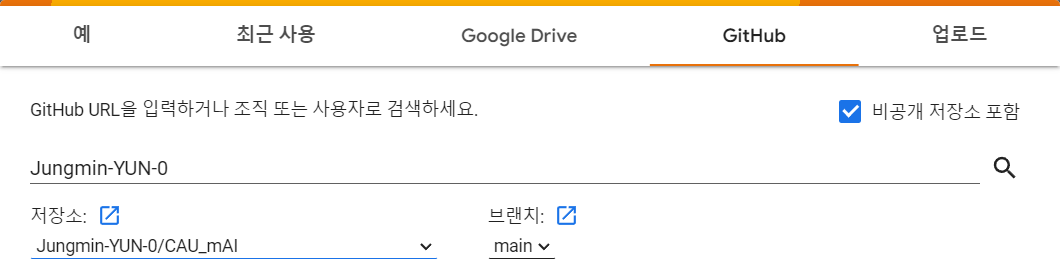

##WEEK 8
=========
### 1. Transformer

### 2. PLM



## 1. Transformer

In [35]:
import numpy as np
import torch
import torch.nn as nn
import random
import math

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # 드롭 아웃
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)

        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [ ]:
class Transformer(nn.Module):
    # Constructor
    def __init__( self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()
        # dim_model(default=512) 트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기
        # num_head (default=8) 멀티헤드 어텐션의 헤드 수
        # num_encoder_layers (default=6) 트랜스포머 모델의 인코더 레이어 수
        # num_decoder_layers (default=6) 트랜스포머 모델의 디코더 레이어 수

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src, Tgt size 는 반드시 (batch_size, src sequence length) 여야 합니다.

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)

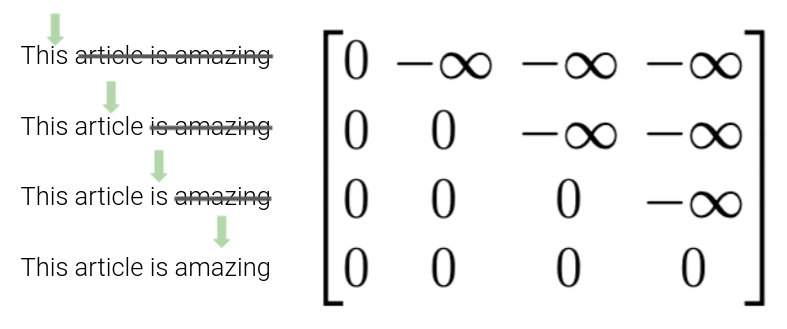

In [48]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)
        X[start::2] = 1
        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1
        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))
        data.append([X, y])
    np.random.shuffle(data)
    return data

# batch_size = 16
def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        if idx + batch_size < len(data):
            if padding:
                max_batch_length = 0
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)
                for seq_idx in range(batch_size):
                    remaining_length = max_batch_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length
            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))
    print(f"{len(batches)} batches of size {batch_size}")
    return batches

train_data = generate_random_data(9000)
print(train_data[:3])
val_data = generate_random_data(3000)
print(val_data[:3])

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

[[array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.])], [array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.])], [array([2., 0., 1., 0., 1., 0., 1., 0., 1., 3.]), array([2., 0., 1., 0., 1., 0., 1., 0., 1., 3.])]]
[[array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.]), array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.])], [array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.])], [array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.]), array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.])]]
562 batches of size 16
187 batches of size 16


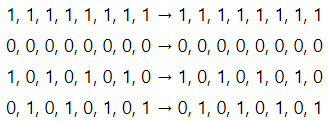

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [40]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        y_input = y[:,:-1]
        y_expected = y[:,1:]

        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        pred = model(X, y_input, tgt_mask)
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

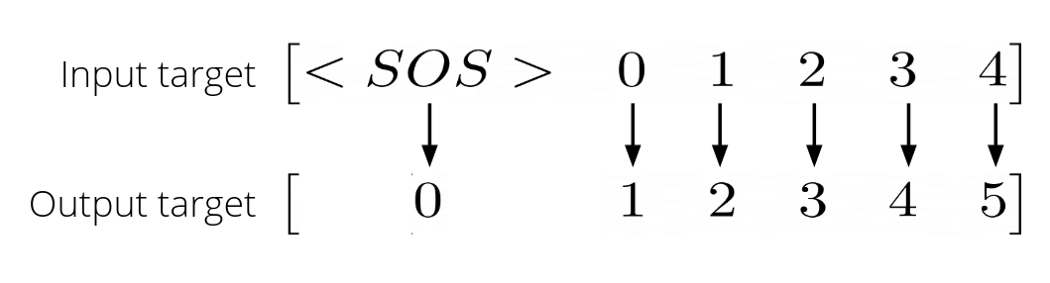

In [41]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            y_input = y[:,:-1]
            y_expected = y[:,1:]

            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            pred = model(X, y_input, tgt_mask)

            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [49]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):  
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        validation_loss = validation_loop(model, loss_fn, val_dataloader)

        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
    return

fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.2474
Validation loss: 0.1884

------------------------- Epoch 2 -------------------------
Training loss: 0.2383
Validation loss: 0.1689

------------------------- Epoch 3 -------------------------
Training loss: 0.2300
Validation loss: 0.1672

------------------------- Epoch 4 -------------------------
Training loss: 0.2241
Validation loss: 0.1770

------------------------- Epoch 5 -------------------------
Training loss: 0.2208
Validation loss: 0.1638

------------------------- Epoch 6 -------------------------
Training loss: 0.2158
Validation loss: 0.1610

------------------------- Epoch 7 -------------------------
Training loss: 0.2143
Validation loss: 0.1442

------------------------- Epoch 8 -------------------------
Training loss: 0.2069
Validation loss: 0.1360

------------------------- Epoch 9 -------------------------
Training loss: 0.2087
Validation loss: 0.1490

-------

In [43]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

        pred = model(input_sequence, y_input, tgt_mask)

        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()


# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 5
Input: [0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]



## 2. PLM

In [1]:
## Transformers installation

! pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 29.8 MB/s 
     |████████████████████████████████| 441 kB 60.0 MB/s 
     |████████████████████████████████| 7.6 MB 53.0 MB/s 
     |████████████████████████████████| 163 kB 73.6 MB/s 
     |████████████████████████████████| 212 kB 68.3 MB/s 
     |████████████████████████████████| 115 kB 75.2 MB/s 
     |████████████████████████████████| 127 kB 31.7 MB/s 
     |████████████████████████████████| 115 kB 52.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Fine-tune a pretrained model

### Prepare a dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")
dataset["train"][100]

  0%|          | 0/2 [00:00<?, ?it/s]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

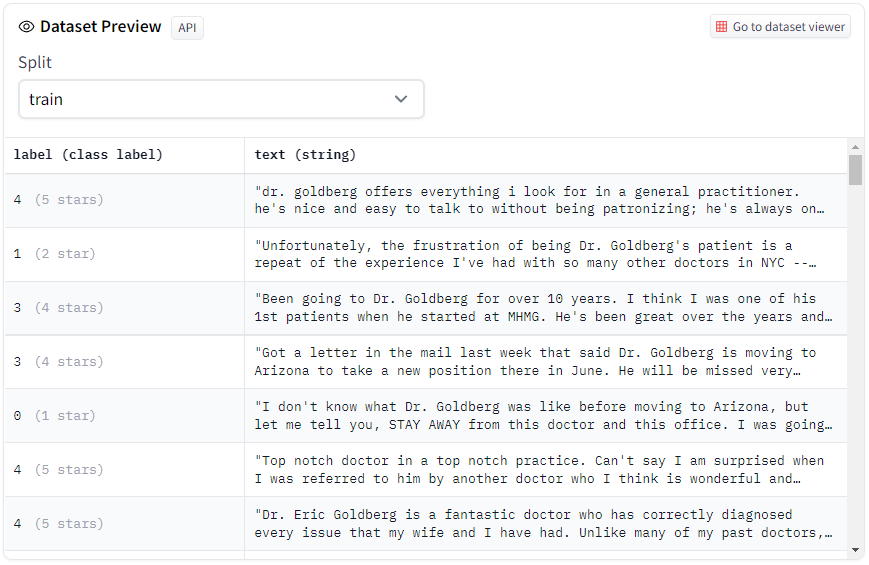

In [3]:
## Tokenization

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [4]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
#small_train_dataset = tokenized_datasets["train"]
#small_eval_dataset = tokenized_datasets["test"]

### Train

In [32]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_

Training Hyperparameters

In [33]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [34]:
'''
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=1,   # batch size per device during training
    per_device_eval_batch_size=10,   # batch size for evaluation
    warmup_steps=1000,               # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=200,               # How often to print logs
    do_train=True,                   # Perform training
    do_eval=True,                    # Perform evaluation
    evaluation_strategy="epoch",     # evalute after eachh epoch
    gradient_accumulation_steps=64,  # total number of steps before back propagation
    fp16=True,                       # Use mixed precision
    fp16_opt_level="02",             # mixed precision mode
    run_name="ProBert-BFD-MS",       # experiment name
    seed=3                           # Seed for experiment reproducibility 3x3
)
'''
# https://huggingface.co/docs/transformers/v4.19.2/en/main_classes/trainer#transformers.TrainingArguments

'\nfrom transformers import TrainingArguments\n\ntraining_args = TrainingArguments(\n    output_dir=\'./results\',          # output directory\n    num_train_epochs=1,              # total number of training epochs\n    per_device_train_batch_size=1,   # batch size per device during training\n    per_device_eval_batch_size=10,   # batch size for evaluation\n    warmup_steps=1000,               # number of warmup steps for learning rate scheduler\n    weight_decay=0.01,               # strength of weight decay\n    logging_dir=\'./logs\',            # directory for storing logs\n    logging_steps=200,               # How often to print logs\n    do_train=True,                   # Perform training\n    do_eval=True,                    # Perform evaluation\n    evaluation_strategy="epoch",     # evalute after eachh epoch\n    gradient_accumulation_steps=64,  # total number of steps before back propagation\n    fp16=True,                       # Use mixed precision\n    fp16_opt_level="02"

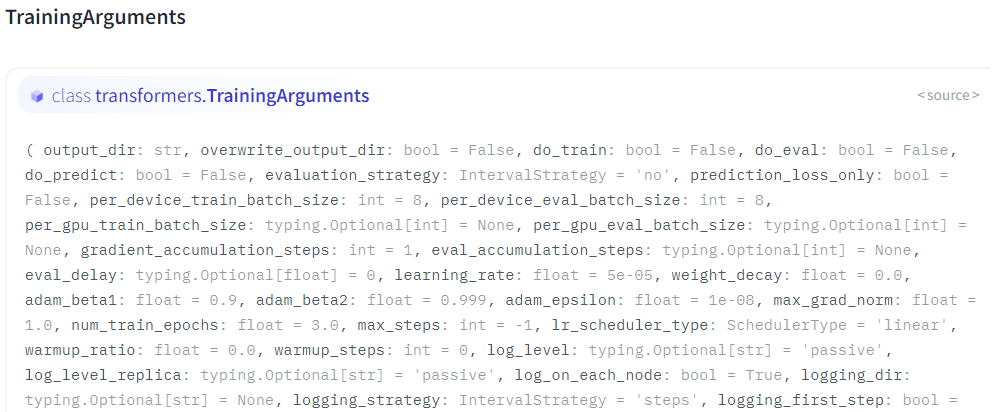

Metrics

In [35]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

In [36]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [40]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", logging_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Trainer

In [41]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [42]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 375


Epoch,Training Loss,Validation Loss,Accuracy
1,0.732200,1.216046,0.564000
2,0.427400,1.213610,0.593000
3,0.203300,1.384643,0.597000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training compl

TrainOutput(global_step=375, training_loss=0.45429579162597655, metrics={'train_runtime': 406.235, 'train_samples_per_second': 7.385, 'train_steps_per_second': 0.923, 'total_flos': 789354427392000.0, 'train_loss': 0.45429579162597655, 'epoch': 3.0})

___

In [ ]:
del model
#del pytorch_model
del trainer
torch.cuda.empty_cache()

In [21]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

In [31]:
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

In [33]:
tokenized_datasets.set_format("torch")

In [24]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))


### Dataloader

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [26]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Optimizer and Learning Rate Scheduler

In [27]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [28]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [29]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Training Loop

In [66]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/375 [00:00<?, ?it/s]

### Metrics

In [67]:
metric = load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.604}

In [ ]:
## additional resources

# Transformers Notebooks contains various notebooks on how to fine-tune a model for specific tasks in PyTorch and TensorFlow
# https://huggingface.co/docs/transformers/main/en/notebooks

### [reference]

https://wikidocs.net/book/7439

https://huggingface.co/docs/transformers